# Setup

https://github.com/facebookresearch/faiss/wiki/Getting-started

**We assume row-major storage, ie. the j'th component of vector number i is stored in row i, column j of the matrix. Faiss uses only 32-bit floating point matrices.**

In [1]:
import numpy as np
import faiss

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Setup

In [3]:
xb = np.concatenate((np.load('pred/feats_train_crop0.npy'),
                     np.load('pred/feats_train_crop1.npy')), axis=0)

yb = np.concatenate((np.load('pred/targs_train_crop0.npy'),
                    np.load('pred/targs_train_crop1.npy')), axis=0)


xq = np.concatenate((np.load('pred/feats_valid_crop0.npy'),
                     np.load('pred/feats_valid_crop1.npy')), axis=0)
                     
yq = np.concatenate((np.load('pred/targs_valid_crop0.npy'),
                     np.load('pred/targs_valid_crop1.npy')), axis=0)

In [4]:
xb.shape # nb-by-d

(115104, 512)

In [5]:
xq.shape # nq-by-d (query vectors)

(30952, 512)

In [6]:
yb.shape, yq.shape

((115104,), (30952,))

In [7]:
## setup
d = xb.shape[1] # 512
nlist = int(4*np.sqrt(xb.shape[0])) # https://github.com/facebookresearch/faiss/issues/112
d, nlist

(512, 1357)

In [8]:
quantizer = faiss.IndexFlatIP(d)
index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

https://github.com/facebookresearch/faiss/wiki/FAQ#how-can-i-index-vectors-for-cosine-distance

In [9]:
xb.max()

237.49567

In [10]:
faiss.normalize_L2(xb)

In [11]:
xb.max()

0.83172184

In [12]:
index.train(xb)

In [13]:
index.add_with_ids(xb, yb)

In [14]:
print(index.is_trained)
print(index.ntotal)

True
115104


## Train dataset

In [15]:
## search
k = 5 # we want to see 5 nearest neighbors
D_train, I_train = index.search(xb, k) # sanity check
print(I_train[:5])
print(yb[:5].reshape((5,1)))
print(D_train[:5])

[[618 970 685 798 120]
 [335 335 335 335 335]
 [156 641 143 594 175]
 [498 498 498 498 498]
 [660 660 660 660 660]]
[[618]
 [335]
 [156]
 [498]
 [660]]
[[0.99999976 0.7270189  0.6722888  0.67143846 0.6603554 ]
 [0.99999994 0.9572699  0.95443046 0.95282394 0.95003927]
 [1.0000001  0.62668186 0.5893097  0.56787115 0.54940975]
 [1.0000002  0.90291166 0.8693811  0.86241686 0.8618237 ]
 [1.0000001  0.9838691  0.9800273  0.97952676 0.9775877 ]]


In [16]:
yb.max(), I_train.max()

(1107, 1107)

### Train accuracy

In [17]:
I_train[:,0].shape, yb.shape

((115104,), (115104,))

In [18]:
# Accuracy
np.equal(I_train[:,0], yb).sum()/len(yb)

1.0

In [19]:
I_train[:10,0], yb[:10]

(array([618, 335, 156, 498, 660, 473, 105, 734, 966, 514]),
 array([618, 335, 156, 498, 660, 473, 105, 734, 966, 514]))

In [20]:
I_train[-10:,0], yb[-10:]

(array([911, 142, 340, 389, 809, 508, 881, 536, 679, 775]),
 array([911, 142, 340, 389, 809, 508, 881, 536, 679, 775]))

### Train confusion matrix

In [21]:
cm = confusion_matrix(I_train[:,0], yb)

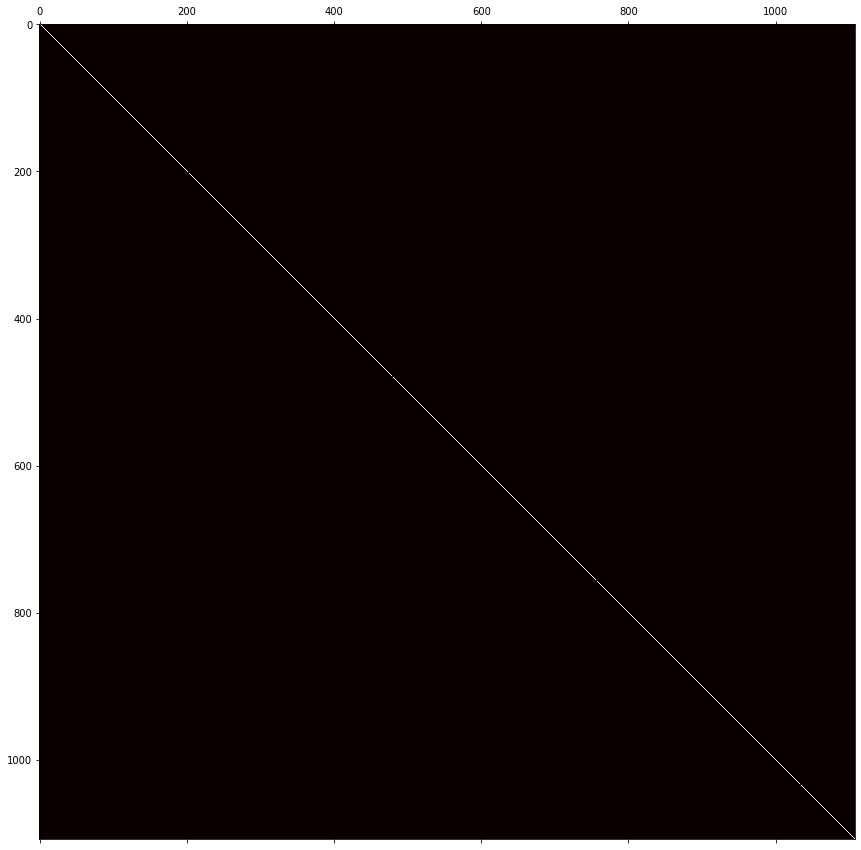

In [22]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

## Valid dataset

In [23]:
xq.max()

80.618484

In [24]:
faiss.normalize_L2(xq)

In [25]:
xq.max()

0.7792703

In [26]:
D_valid, I_valid = index.search(xq, k) # actual search

In [27]:
xq.shape, yq.shape

((30952, 512), (30952,))

In [28]:
I_valid.shape, D_valid.shape

((30952, 5), (30952, 5))

In [29]:
print(I_valid[:5]) # neighbors of the 5 first queries
print(yq[:5].reshape((5,1)))
print(D_valid[:5])

[[ 952   48  702  666  281]
 [  11   11  282  282   11]
 [ 876  420  336  227 1077]
 [ 505  528  505  505  505]
 [ 590  268   91  268  581]]
[[352]
 [361]
 [503]
 [505]
 [ 70]]
[[0.56105745 0.5441821  0.5376414  0.5070796  0.49422914]
 [0.79933316 0.7606996  0.74748874 0.7352704  0.7344019 ]
 [0.6341188  0.6015303  0.57087356 0.5640763  0.56232023]
 [0.80163383 0.72295684 0.71974325 0.71347475 0.7103033 ]
 [0.76994777 0.75657517 0.7525774  0.69243985 0.6812178 ]]


In [30]:
print(I_valid[-5:]) # neighbors of the 5 last queries
print(yq[-5:].reshape((5,1)))
print(D_valid[-5:])

[[ 514  109 1060 1096  884]
 [ 202  510  202  252  565]
 [ 699  699  699  699  699]
 [ 809  606  528  954  519]
 [ 595  283  595  502  283]]
[[103]
 [202]
 [824]
 [328]
 [509]]
[[0.71984315 0.6162831  0.5941847  0.58852035 0.5723684 ]
 [0.6416633  0.5900804  0.5707389  0.5673437  0.5604843 ]
 [0.7341248  0.7217541  0.71027046 0.7082623  0.7070271 ]
 [0.708073   0.65572673 0.639145   0.63201076 0.6293016 ]
 [0.6267748  0.5574877  0.5544461  0.54849565 0.5191979 ]]


In [31]:
np.save('pred/preds_valid.npy', I_valid)

### Valid accuracy

In [32]:
I_valid[:,0]

array([952,  11, 876, ..., 699, 809, 595])

In [33]:
yq

array([352, 361, 503, ..., 824, 328, 509])

In [34]:
# Correct elements
np.equal(I_valid[:,0], yq).sum()

10348

In [35]:
# Accuracy
np.equal(I_valid[:,0], yq).sum()/len(yq)

0.3343241147583355

In [36]:
valid_correct = np.equal(I_valid[:,0], yq)

In [37]:
valid_correct

array([False, False, False, ..., False, False, False])

In [38]:
np.save('pred/preds_valid_correct.npy', valid_correct)

### Valid confusion matrix

In [39]:
cm = confusion_matrix(I_valid[:,0], yq)

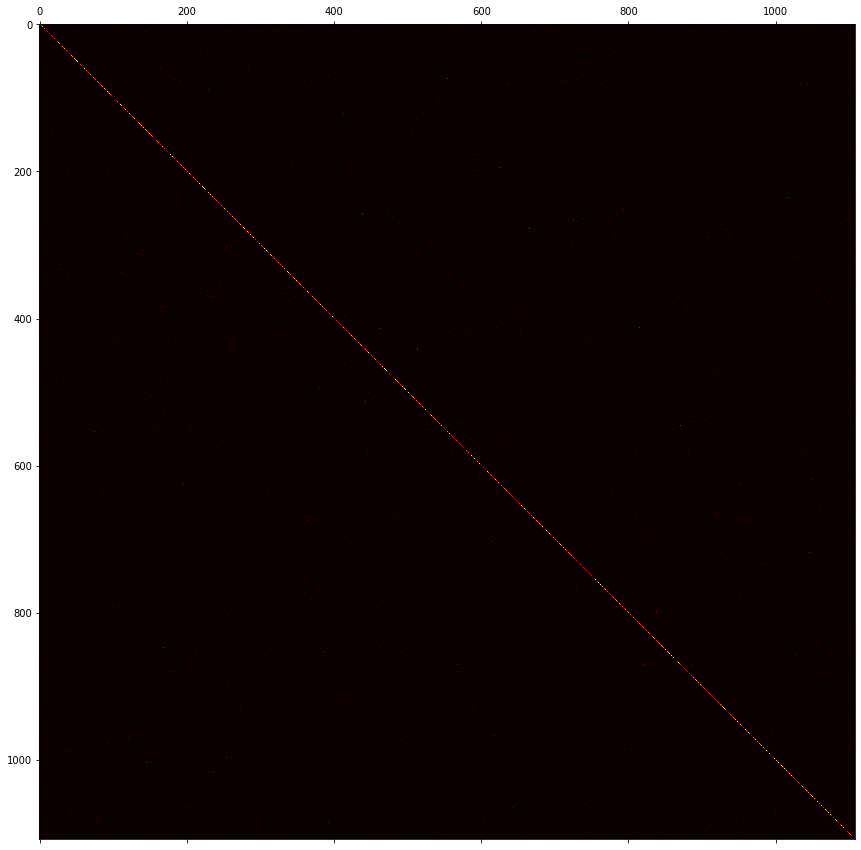

In [40]:
fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(cm, cmap='hot')

#### Work in progress

In [41]:
cm.shape

(1108, 1108)

In [42]:
np.eye(1108, dtype=bool)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ..., False,  True, False],
       [False, False, False, ..., False, False,  True]])

In [43]:
cm[np.eye(1108, dtype=bool)].sum()

1506

In [44]:
cm[~np.eye(1108, dtype=bool)].sum()

6232

In [45]:
cm[np.eye(1108, dtype=bool)].sum()/(cm[~np.eye(1108, dtype=bool)].sum() + cm[np.eye(1108, dtype=bool)].sum())

0.19462393383303178

In [46]:
~np.eye(1108, dtype=bool)

array([[False,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True, False,  True],
       [ True,  True,  True, ...,  True,  True, False]])

In [47]:
cm[~np.eye(1108, dtype=bool)]

array([0, 0, 0, ..., 0, 0, 0])

In [48]:
-(np.eye(1108)-1)

array([[-0.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., -0.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., -0., ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., -0.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., -0.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., -0.]])

In [49]:
cm * -(np.eye(1108)-1)

array([[-0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0., -0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., -0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., -0.]])

In [50]:
cm_wodia = (cm * -(np.eye(1108)-1))

In [51]:
cm_wodia.shape

(1108, 1108)

In [52]:
cm_wodia.sum(axis=0)

array([3., 5., 4., ..., 7., 6., 5.])

In [53]:
cm_wodia.sum(axis=1)

array([ 9.,  6.,  1., ...,  3., 10.,  4.])

In [73]:
# from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
#def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, classes=np.unique(yq),
                      title='Confusion matrix, without normalization')
plt.show()

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(I_test[:,0], yq, #classes=np.unique(yq), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Test dataset

In [41]:
xq_test = np.load('pred/feats_test.npy')

In [41]:
xq_test = np.concatenate((np.load('pred/feats_test_crop0.npy'),
                          np.load('pred/feats_test_crop1.npy')), axis=0)

In [42]:
xq_test.max()

152.81253

In [43]:
faiss.normalize_L2(xq_test)

In [44]:
xq_test.max()

0.8023675

In [45]:
D_test, I_test = index.search(xq_test, k) # actual search

In [46]:
xq_test.shape, I_test.shape, D_test.shape

((39794, 512), (39794, 5), (39794, 5))

In [47]:
print(I_test[:5]) # neighbors of the 5 first queries
print(D_test[:5])

[[381 381 381 381 381]
 [208  94 626 124 427]
 [277 277 277 277 277]
 [658 640  32 707 349]
 [565 585 321 585 585]]
[[0.8186562  0.7868278  0.7818629  0.7803631  0.77626324]
 [0.55243564 0.53941494 0.5351189  0.5114602  0.5101799 ]
 [0.5132828  0.491616   0.491379   0.47564816 0.46828264]
 [0.6563801  0.6528276  0.65024185 0.64949316 0.63889956]
 [0.8331481  0.7868031  0.7856852  0.7817739  0.7734299 ]]


In [48]:
print(I_test[-5:]) # neighbors of the 5 last queries
print(D_test[-5:])

[[  26   26   26   26   26]
 [ 316  316  316  316  273]
 [ 273  273  273  273  273]
 [1026 1026 1026 1026 1026]
 [1084  147 1018  656  983]]
[[0.7490437  0.74635834 0.680001   0.677587   0.66023326]
 [0.756034   0.7141101  0.70269525 0.6975144  0.6790437 ]
 [0.5348149  0.5227273  0.50084054 0.49985737 0.4925897 ]
 [0.60515404 0.56436026 0.56363523 0.5543049  0.55340254]
 [0.610207   0.5373004  0.4953732  0.4836065  0.46593788]]


In [49]:
I_test[2]

array([277, 277, 277, 277, 277])

In [50]:
np.unique(I_test[2], return_counts=True)

(array([277]), array([5]))

In [51]:
preds_test = I_test[:,0]
dist_test = D_test[:,0]

In [52]:
np.save('pred/preds_test.npy', preds_test)
np.save('pred/dist_test.npy', dist_test)

#### Get mode or most similiar if mode is 1

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mode.html#scipy.stats.mode

**This seems to not increase the accuracy !!!**

In [27]:
from scipy import stats

In [28]:
# get mode and mode count
I_test_mode = stats.mode(I_test, axis=1)

In [29]:
I_test.shape, I_test_mode[0].shape

((39794, 5), (39794, 1))

In [30]:
I_test[:5]

array([[ 591,  591,  587,  591,  855],
       [ 736,  770,  387,  728,  933],
       [ 179,  576,  191,  451, 1076],
       [ 908,  908,  609,  256,  892],
       [ 775,  445,  970,  387,  307]])

In [31]:
I_test_mode[0][:5]

array([[591],
       [387],
       [179],
       [908],
       [307]])

In [32]:
I_test_mode[1][:5]

array([[3],
       [1],
       [1],
       [2],
       [1]])

In [33]:
I_test_mode[1] == 1

array([[False],
       [ True],
       [ True],
       ...,
       [False],
       [False],
       [False]])

In [34]:
mode_mask = (~(I_test_mode[1] == 1)).astype('float')
similar_mask = (I_test_mode[1] == 1).astype('float')

In [35]:
mode_mask[:5]

array([[1.],
       [0.],
       [0.],
       [1.],
       [0.]])

In [36]:
similar_mask[:5]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

In [37]:
I_test[:,0]

array([ 591,  736,  179, ...,  108, 1074,  316])

In [38]:
similar_mask.shape

(39794, 1)

In [39]:
I_test[:,0].shape, similar_mask.shape

((39794,), (39794, 1))

In [40]:
I_test[:,0].reshape((-1,1)).shape

(39794, 1)

In [41]:
I_most_similar = np.multiply(I_test[:,0].reshape((-1,1)),similar_mask)

In [42]:
I_most_similar[:5]

array([[  0.],
       [736.],
       [179.],
       [  0.],
       [775.]])

In [43]:
I_higher_mode = np.multiply(I_test_mode[0],mode_mask)

In [44]:
I_higher_mode[:5]

array([[591.],
       [  0.],
       [  0.],
       [908.],
       [  0.]])

In [45]:
preds_similar_mode = I_most_similar + I_higher_mode

In [46]:
preds_similar_mode[:5]

array([[591.],
       [736.],
       [179.],
       [908.],
       [775.]])

In [51]:
np.save('pred/preds_test_similar_mask', similar_mask)
np.save('pred/preds_test_mode_mask', mode_mask)
np.save('pred/preds_test_similar_mode', preds_similar_mode)